In [1]:
#meta 5/23/2022 L22 Time Series Analysis (TSA) - 1st draft
#Source: the Great Courses Statistics: Concepts and Applications in R 
#Professor: Talithia Williams

#Relevant references
#  simple TS Linear model
# refer to https://github.com/anyaconda/myStats/blob/master/myTutorial_Linear_TimeSeriesForecasting.ipynb


#history
# 5/23/2022 TSA 1ST DRAFT
#      Model TS as linear ($note: no proper scaling)
#      Model TS: concepts and application
#      1st sweep at L22 with py
#      additional myVis 
#$todo, $video, video; to org

#Reference
#TSA in python
# refer to http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [2]:
import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import time #to track performance time
from datetime import datetime
import matplotlib.pyplot as plt

#modeling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

#stat modeling
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from math import sqrt
from scipy.stats import pearsonr, shapiro


'''#import scipy.stats as scs
t
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
'''

print(pd.__version__, np.__version__)

1.0.3 1.21.0


# Time Series Analysis
Gives us a way to model the response data that's correlated with itself from one point in time to the next - data that has a time dependence.

Here, a single measurement from a population and we want to understand that measurement changes over time.  `Time` is the independent predictor var, and our goal is to understand how our response `y` varies with respect to time. 

##### Time Series Analysis
1. Describe: identify patterns, trends, and seasonal variation  
2. Explain: understand and model the data  
3. Forecast: predict short-term trends from previous patterns

The goal is to develop a stat model that describes and explains the data in such a way that forecasting can occur. 

# Pattern: Trends 
Tend to be linear, quadratic, or even exponential. 

## 0. Load Data
R dataset `TSA` `wages` contains monthly values of the average hourly wages (in US$), for workers in the US apparel and textile products industry, from 07/1981 through 06/1987. 

https://cran.r-project.org/web/packages/TSA/TSA.pdf

Workaround: Temporarily using Simulated dataset

In [3]:
# Simulated dataset
np.random.seed(37)
n_samples = 6 * 12

y = np.linspace(50,75, num =n_samples)
w = np.random.normal(0.2, 0.9, size=n_samples)
for t in range(n_samples):
    y[t] = y[t-1] + w[t]
    
#$dates - create a date range for df indexing by date
# refer to https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
start_date = datetime.strptime('07/1981', '%m/%Y')
end_date = datetime.strptime('07/1987', '%m/%Y')
x_dates = pd.date_range(start=start_date, end=end_date, freq = 'M')

#preview
#x_dates

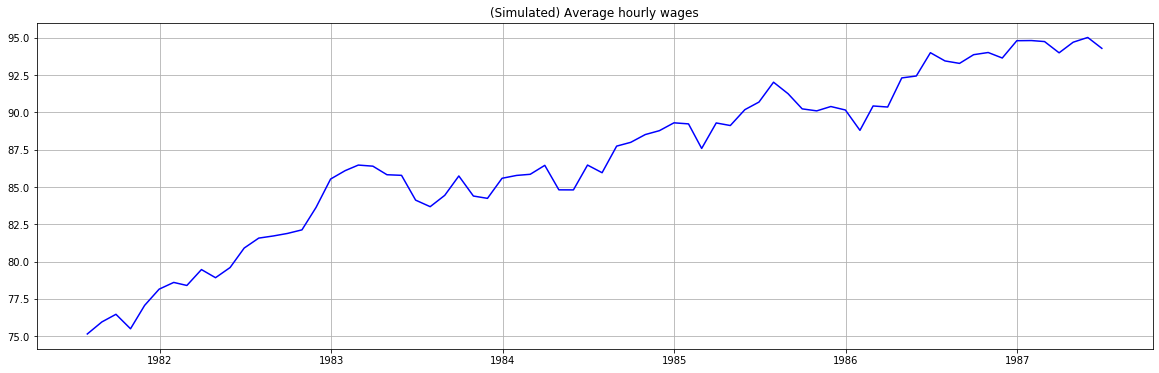

In [4]:
#vis TS plot
plt.figure(figsize=(20, 6))
plt.plot(x_dates, y, c='b')
plt.title('(Simulated) Average hourly wages')
plt.grid(True)
plt.show()

Plot shows a nice (linear) increasing trend.

0.2523052531661304 77.92518608175077


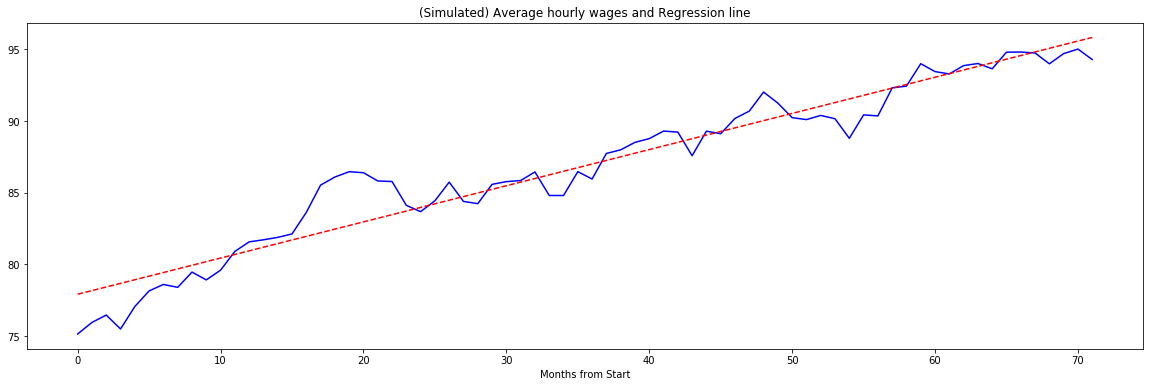

In [5]:
x = np.arange(0, n_samples)

#create basic scatterplot
plt.figure(figsize=(20, 6))
plt.plot(x, y, 'b')
plt.title('(Simulated) Average hourly wages and Regression line')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
print(m,b)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, 'r--')
plt.xlabel('Months from Start');

## 2. Model

### 2.1 Model as Linear

#### 2.1a Try Linear regression

In [6]:
#reshape input variables x for input to the model
x = x.reshape(-1, 1)
print(x.shape)

(72, 1)


In [7]:
#linear model
model = LinearRegression().fit(x, y)
print("R_sqrd score: ", model.score(x, y))
model.coef_, model.intercept_

R_sqrd score:  0.9325849859177486


(array([0.2523]), 77.9251860817508)

In [8]:
#Measure model perf: rmse
y_hat = model.predict(x)
sqrt(mean_squared_error(y_hat, y))

1.4098093270559757

##### Verify model
with a few predictions

In [9]:
#predict some
y_hat_idx = [[1], [7], [50]]
y_hat_some = model.predict(y_hat_idx)
y_hat_some

array([78.1775, 79.6913, 90.5404])

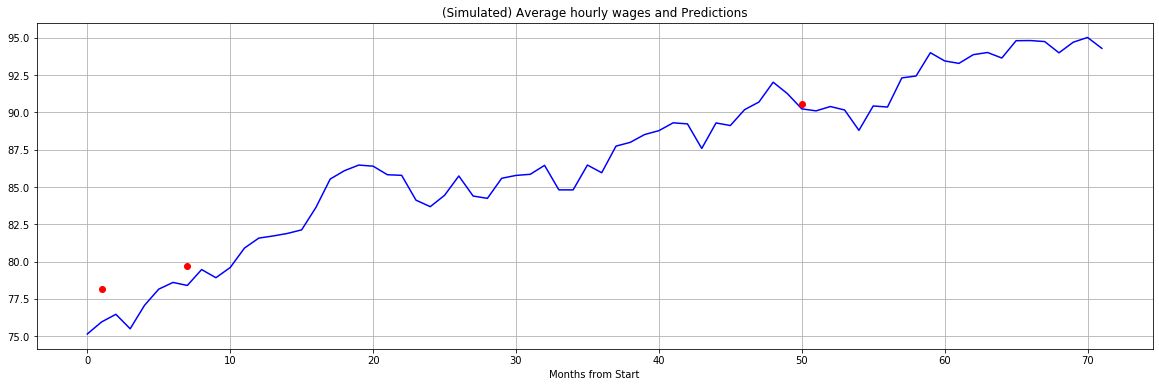

In [10]:
#vis - some
plt.figure(figsize=(20, 6))
plt.plot(x, y, 'b')
plt.plot(y_hat_idx, y_hat_some, 'ro')
plt.title('(Simulated) Average hourly wages and Predictions')
plt.xlabel('Months from Start');
plt.grid(True)
plt.show()

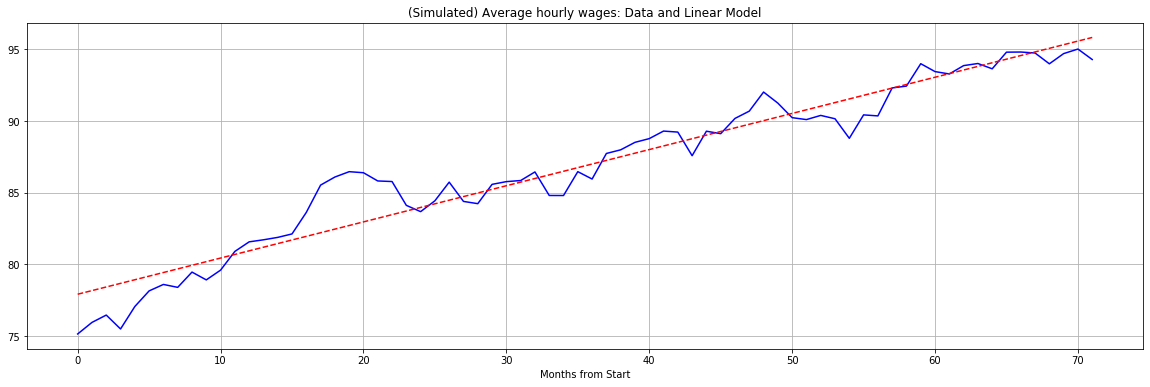

In [11]:
#vis - all
plt.figure(figsize=(20, 6))
plt.plot(x, y, 'b')
plt.plot(x, y_hat, 'r--')
plt.title('(Simulated) Average hourly wages: Data and Linear Model')
plt.xlabel('Months from Start');
plt.grid(True)
plt.show()

`R squared` is high, indicates a good model?

##### Check residuals
for normality and independence - should look like noise (without pattern or trend)

The desirable result: correlation = 0  
Residuals should be unrelated to each other

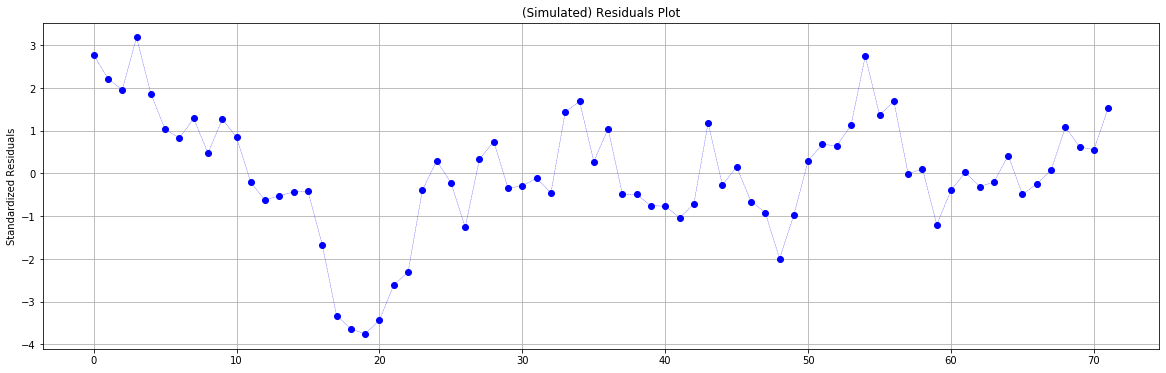

In [12]:
res = y_hat - y

plt.figure(figsize=(20, 6))
plt.plot(x, res, 'bo--', linewidth=0.3)
plt.ylabel('Standardized Residuals')
plt.title('(Simulated) Residuals Plot')
plt.grid(True)
plt.show()

In [13]:
# calculate Pearson's correlation
len_res = len(res)

corr, _ = pearsonr(res[:(len_res - 1)], res[1:])
print('Pearsons correlation: %.8f' % corr)

Pearsons correlation: 0.79874666


Clearly some pattern in residuals: not centered around 0 and don't look random (tend to hang together to closely)

Suggests that there's still more structure to take out from the data.

#### 2.1b Try Polynomial regression
Quadratic fit

In [14]:
#sklearn.preprocessing.PolynomialFeatures¶
#refer to https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

poly = PolynomialFeatures(2)
x_poly = poly.fit_transform(x)

X = x_poly[:,-2:]

In [15]:
model_poly = LinearRegression().fit(X, y)
print("R_sqrd score: ", model_poly.score(X, y))
model_poly.coef_, model_poly.intercept_

R_sqrd score:  0.9443389823359979


(array([ 0.3605, -0.0015]), 76.66260072455972)

In [16]:
#predict 
y_hat = model_poly.predict(X)
#y_hat

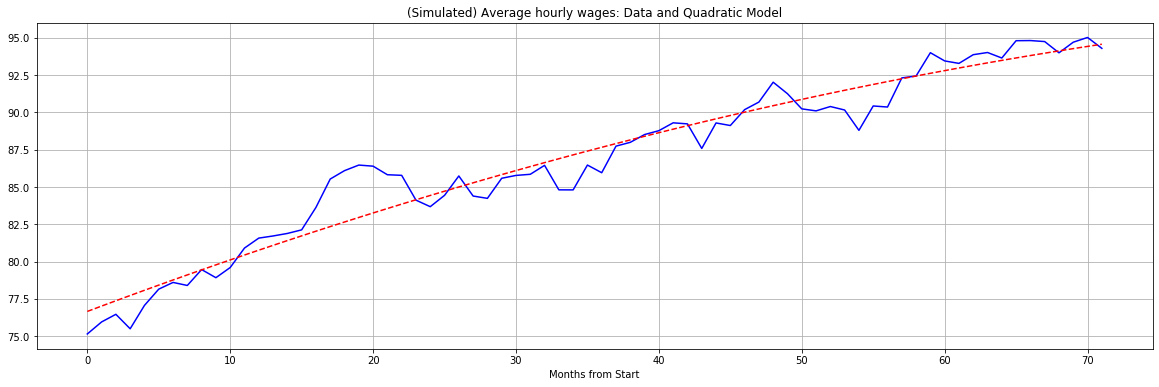

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(x, y, 'b')
plt.plot(x, y_hat, 'r--')
plt.title('(Simulated) Average hourly wages: Data and Quadratic Model')
plt.xlabel('Months from Start');
plt.grid(True)
plt.show()

`R squared` is even higher, indicates a better model?

#####  Check residuals

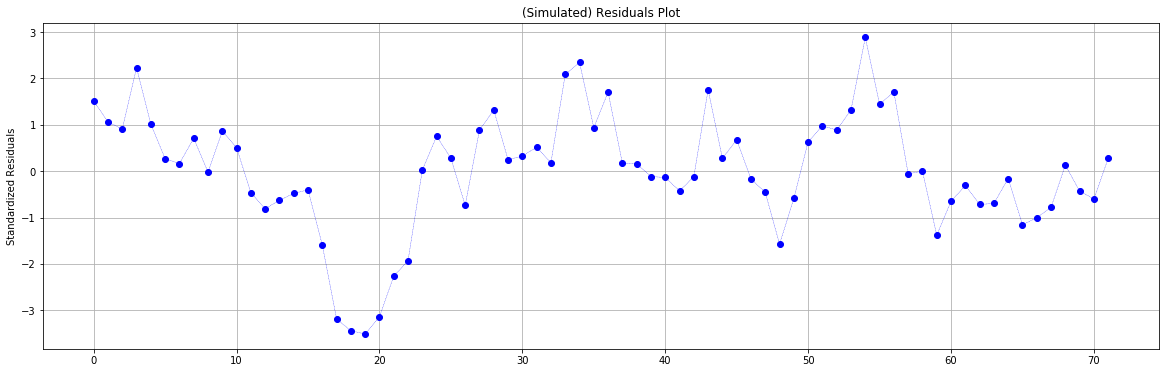

In [18]:
res = y_hat - y

plt.figure(figsize=(20, 6))
plt.plot(x, res, 'bo--', linewidth=0.3)
plt.ylabel('Standardized Residuals')
plt.title('(Simulated) Residuals Plot')
plt.grid(True)
plt.show()

In [19]:
# calculate Pearson's correlation
len_res = len(res)

corr, _ = pearsonr(res[:(len_res - 1)], res[1:])
print('Pearsons correlation: %.8f' % corr)

Pearsons correlation: 0.76525175


##### Check residuals for normality
with histogram

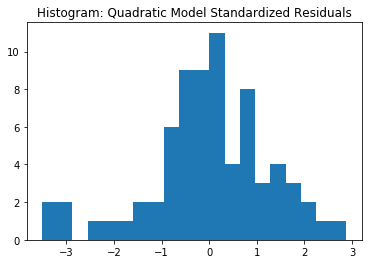

In [20]:
plt.hist(res, bins = 20)
plt.title( "Histogram: Quadratic Model Standardized Residuals");

Looks pretty normal, but can't just eye-ball a histogram
##### Check residuals for normality
with Q-Q plot

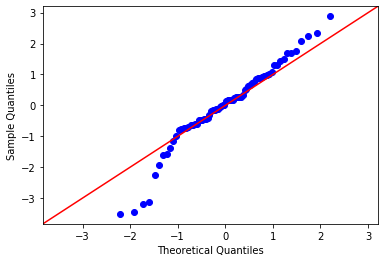

In [21]:
#statsmodels.graphics.gofplots.qqplot
#refer to https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html
sm.qqplot(res, line ='45')
plt.show; #or py.show; import pylab as py

Doesn't look normal, but can't just eye-ball a QQ plot either

##### Check residuals for normality
with Shapiro test

`Shapiro-Wilk` test is a test of normality.  In frequentist statistics, it determines whether the given sample comes from the normal distribution or not. The null hypothesis of Shapiro’s test is that the population is distributed normally.  
- Ho(Accepted): Sample is from the normal distributions.(Po>0.05)  
- Ha(Rejected): Sample is not from the normal distributions.

In [22]:
# conduct the  Shapiro-Wilk Test
#How to Perform a Shapiro-Wilk Test in Python
# refer to https://www.geeksforgeeks.org/how-to-perform-a-shapiro-wilk-test-in-python/
shapiro(res)

ShapiroResult(statistic=0.9594705104827881, pvalue=0.020625561475753784)

Interpretation: Since in the above example, the p-value is less than the alpha(0.05) then we reject the null hypothesis i.e. we have sufficient evidence to say that sample does not come from a normal distribution.

Have p-value statistically significant so it means our residuals are not normally distributed.

To identify the possible structure of ts data, can use ACF (more later).

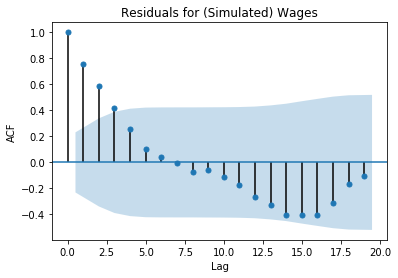

In [51]:
smt.graphics.plot_acf(res)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Residuals for (Simulated) Wages')
plt.show()

### 2.2 Model Time Series

Have `y1, y2, y3` - sequence of `y` variables.  
Now have `y_t` as the value `y` at time `t`.

Statistical questions:  
- expected value  
- variance  
- covariance  (def: how two different vars vary together)
- is there correlation in this new context?

Notation changes  

![Time Series Notation](img/L22_TimeSeriesNotation.PNG)

- autocovariance (def: varying with myself)  
- autocorrelation (def: how correlated series with itself)  
High autocorrelation implies strong linear dependence between `y_t` and `y_s`.  
Weak autocorrelation (near 0) means not much  linear dependency in your data.  
Autocorrelation = 0 means your series is independent.

$video min11:30
#### 2.2.0 Concepts

##### Stationary
A stationary ts process has a constant mean, a constant variance, and a constant covariance fn that is independent of time.
We need the processes to be stationary before we can predict them. Non-stationary processes can't be forecasted.  We must transform non-stationary data to stationary before moving forward to evaluation.


##### Patterns
TS in general often contains  
- trends  
a consistent directional movement; can be either deterministic or stochastic  
- seasonality  
cyclical fluctuatiolns that reoccur seasonally throught a period  
- serial dependence  
like autocorrelation, but the dependence implies causality


#### 2.2.1 Model types
Objective is to determine a model that describes the pattern of the time series
- AR(p)  
Auto-regressive model relates the present value of a series to past values, where `p` is the number of lags and the number of steps to look in the past  
![Time Series Notation](img/L22_TimeSeries_AR_model.PNG)  

The assumptions of `AR(1)` model:  
1) the errors are independently distributed with a normal distribution that has mean 0 and constanct variance  
2) the errors are independent of `y_t'

- MA(q)  
Moving average model relate the present value of a series to past prediction errors  

![Time Series Notation](img/L22_TimeSeries_MA_model.PNG)  

These past prediction errors have to be estimated by nonlinear methods and are knowns as moving average terms in the model.  
In the `MA(q)` way of thinking, the observations of a random var at time `t` are affected by the shock at time `t(e_t)` and by the shocks that have taken place before time `t`.

- ARMA  
Together AR and MA models  

- ARIMA  
When we include differencing `y_t - y_t-1`, we get ARIMA models.  ARIMA series often have an underlying linear trend and sometimes contain seasonality.

# Pattern: Seasonal Series
Seasonality is any kind of periodicity.  A ts repeats itself after a regular period of time (i.e. the business cycle in economics)

## 0. Load Data
R dataset `airpass` contains monthly totals of a US airline passengers, from 1949 to 1960.  
Refer to source https://www.kaggle.com/datasets/rakannimer/air-passengers

In [27]:
#load ds
df = pd.read_csv('data/AirPassengers.csv') #, index_col=['Time'], parse_dates=['Time'])
df['Month'] = pd.to_datetime(df['Month'])
df.dtypes

#preview
print(df.shape)
#date range
print(df['Month'].min(), df['Month'].max())
df.head()

(144, 2)
1949-01-01 00:00:00 1960-12-01 00:00:00


,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## 1. Prep Data

In [28]:
x = df['Month']
y = df['#Passengers']

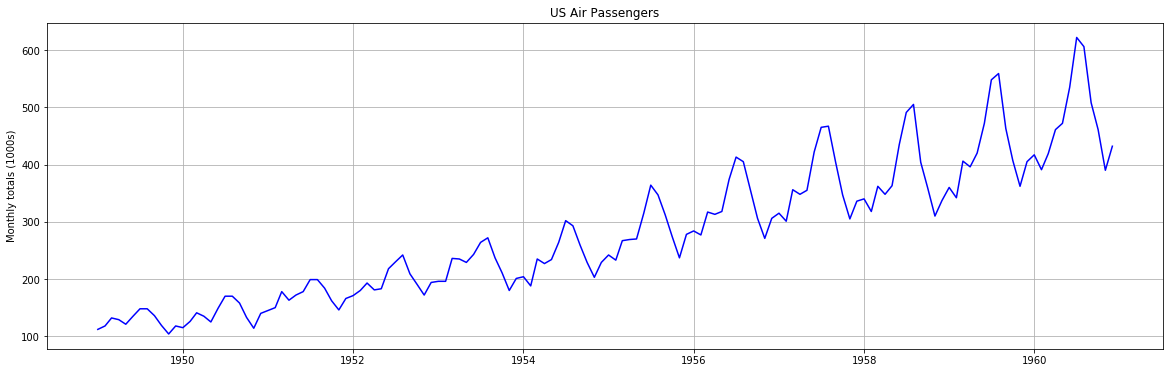

In [29]:
#vis TS plot
plt.figure(figsize=(20, 6))
plt.plot(x, y, c='b')
plt.ylabel('Monthly totals (1000s)')
plt.title('US Air Passengers')
plt.grid(True)
plt.show()

$video heterscadacity -> transform

In [30]:
df['Log_#Passengers'] = np.log1p(df['#Passengers'])
df.head()

,Month,#Passengers,Log_#Passengers
0,1949-01-01,112,4.727388
1,1949-02-01,118,4.779123
2,1949-03-01,132,4.890349
3,1949-04-01,129,4.867534
4,1949-05-01,121,4.804021


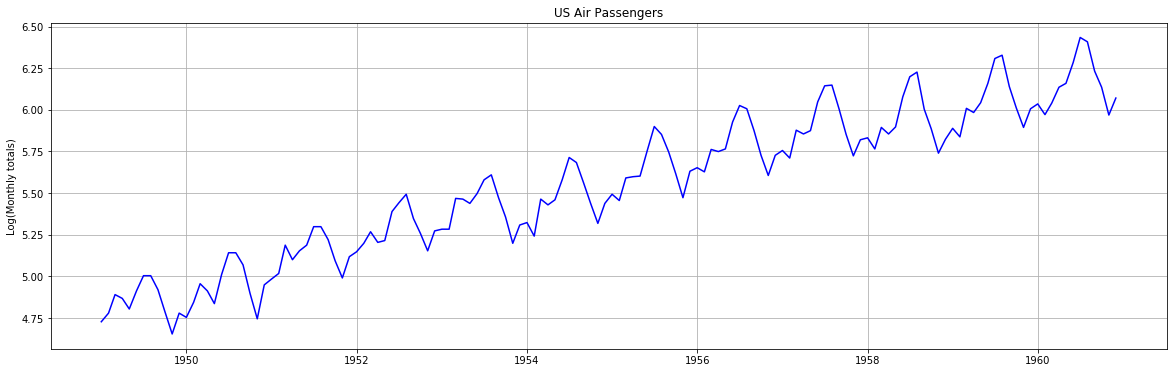

In [31]:
x = df['Month']
y = df['Log_#Passengers']
plt.figure(figsize=(20, 6))
plt.plot(x, y, c='b')
plt.ylabel('Log(Monthly totals)')
plt.title('US Air Passengers')
plt.grid(True)
plt.show()

Log transformation has removed the increasing variability (heteroscadacity).  The plot displays a much more constant variation around the upward trend.  

#### Differencing Methods
Used to model and remove the effect of trends (linear, quadratic, etc) in the data.  

#####  1st Difference
of a ts is the series changes from one period to the next.  
Notation:  `y_t - y_t-1`

In [32]:
#$manual
m1 = np.array(df.loc[:(df.shape[0] -2),'Log_#Passengers'])
m2 = np.array(df.loc[1:, 'Log_#Passengers'])

#shape should be len -1 = 143
print(m1.shape, m2.shape)
(m2 - m1)[:5]

(143,) (143,)


array([ 0.0517,  0.1112, -0.0228, -0.0635,  0.1086])

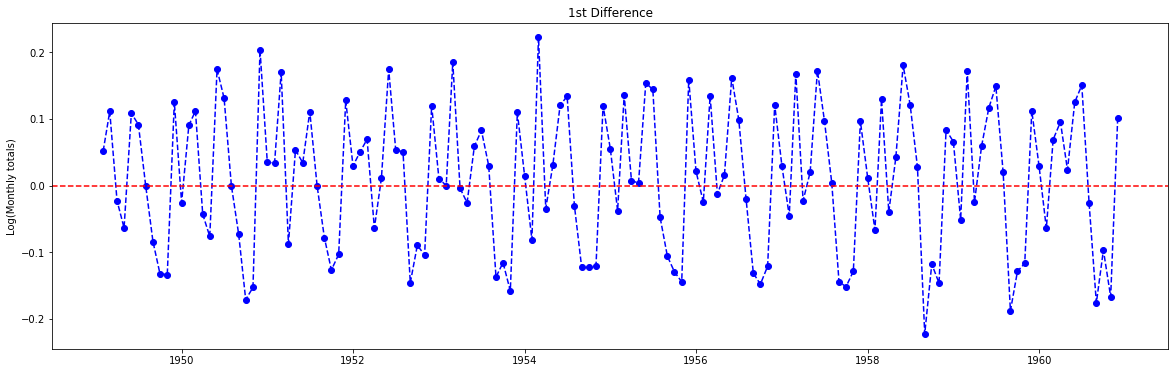

In [33]:
#$manual
plt.figure(figsize=(20,6))
plt.plot(x[1:], (m2 - m1),  'bo', linestyle='--')
plt.ylabel('Log(Monthly totals)')
plt.title('1st Difference')
plt.axhline(y=0.0, linestyle='--', c='r')
plt.show()

In [34]:
#$note $dynamic: identical to above 
START_LEN = df.shape[0]
LAG1 = 1

m1 = np.array(df.loc[:(df.shape[0] -(1+LAG1)),'Log_#Passengers'])
m2 = np.array(df.loc[LAG1:, 'Log_#Passengers'])
d1 = m2 - m1
len_d1 = d1.shape[0]

#shape should be START_LEN - LAG1 = 143
print(START_LEN, len_d1) #m1.shape, m2.shape, d1.shape, 
d1[:5]

144 143


array([ 0.0517,  0.1112, -0.0228, -0.0635,  0.1086])

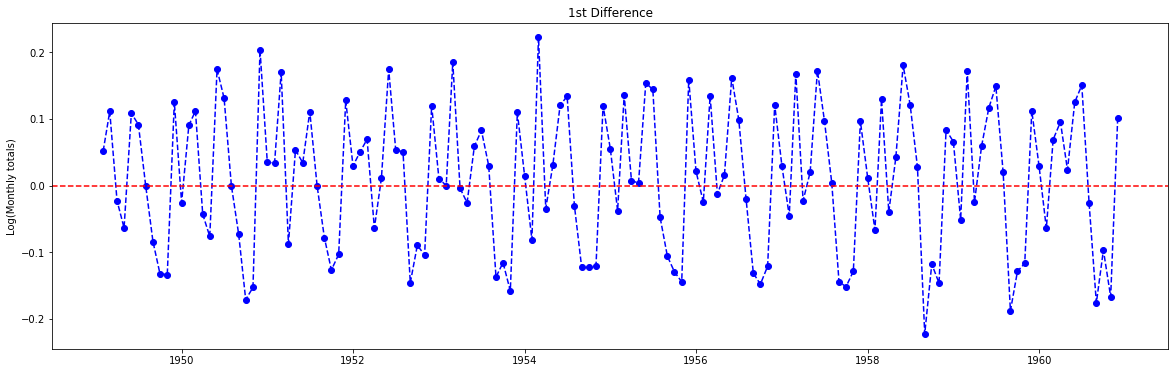

In [35]:
plt.figure(figsize=(20,6))
plt.plot(x[LAG1:], d1,  'bo', linestyle='--')
plt.ylabel('Log(Monthly totals)')
plt.title('1st Difference')
plt.axhline(y=0.0, linestyle='--', c='r')
plt.show()

$todo pg.343 - label plot with the month

The seasonality can be observed by looking at the plotted months - Sep, Oct, Nov are mostly at the low point and Dec at high points. 

##### 1st and Seasonal Differences 
take the log, take the 1st diff and take the seasonal diff

Notation: Difference `y_t - y_t-12` $todo video 


In [36]:
#dynamic
SEASON_LAG = 12
d2 = d1[SEASON_LAG:] - d1[:(len_d1 - SEASON_LAG)]
len_d2 = d2.shape[0]

#shape should be START_LEN - LAG1 - SEASON_LAG = 131
print(len_d1, len_d2) #m1.shape, m2.shape, d1.shape, 
d2[:5]

143 131


array([ 0.0389,  0.0004, -0.0204, -0.0129,  0.0657])

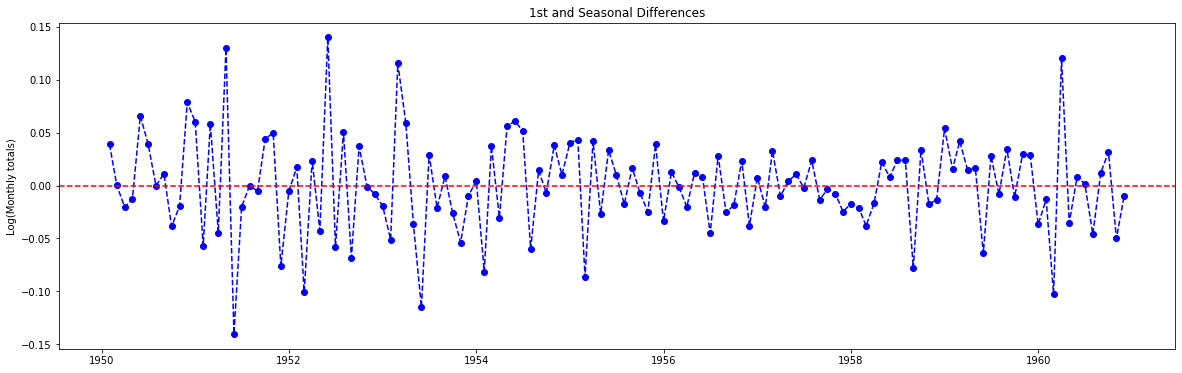

In [37]:
#$manual
plt.figure(figsize=(20,6))
plt.plot(x[(LAG1 + SEASON_LAG):], d2,  'bo', linestyle='--')
plt.ylabel('Log(Monthly totals)')
plt.title('1st and Seasonal Differences')
plt.axhline(y=0.0, linestyle='--', c='r')
plt.show()

$todo pg.344 - label plot with the month

The seasonality is much less obvious now, i.e. some Decembers are high and some low.

Concluison: We've accounted for the structure in our data.  

## 2.0 Diagnostics
#### Test Stationarity
How much is the ts correlated with itself?

Use `ACF` (AutoCorrelation function).  `ACF` gives correlations between ts and lagged values.  It can be used to identify the possible structure of ts data.  Disclaimer: often isn't a clear cut interpretation of ACF.  `ACF of the residuals` of a model is also useful.

The ideal for an `ACF of residuals` is that there aren't any significant correlations for any lag, because then your model has taken into account all of the sructure in the data ($ac move up to wages part)

`statsmodels.graphics.tsaplots.plot_acf`  
Refer to 
https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

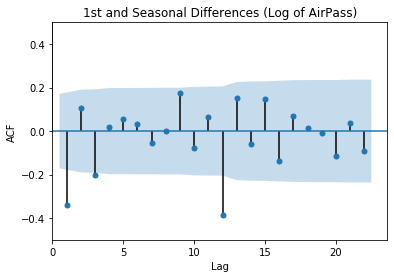

In [52]:
LAGS = LAG1 + SEASON_LAG
smt.graphics.plot_acf(d2)
plt.xlim(0)
plt.ylim(-0.5, 0.5)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('1st and Seasonal Differences (Log of AirPass)')
plt.show()

Shaded blue indicate bounds of stat significance.  

Use `PACF` (Partial AutoCorrelation function).  `PACF` is a conditional correlation.  It's the correlation between 2 points on a ts, under the assumption that we take into account the values in between those 2 points. 

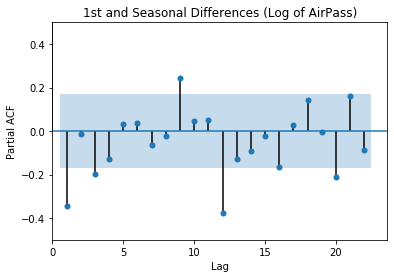

In [54]:
smt.graphics.plot_pacf(d2)
plt.xlim(0)
plt.ylim(-0.5, 0.5)
plt.xlabel('Lag')
plt.ylabel('Partial ACF')
plt.title('1st and Seasonal Differences (Log of AirPass)')
plt.show()

Conclusion: the most prominent autocorrelations are at lags 1 and 12.

## 2.  Model data
based on MA

Let's fit a seasonal `ARIMA` model to the logged ts.
![ARIMA model](img/L22_TimeSeries_ARIMA_model.PNG)

`statsmodels.tsa.arima.model.ARIMA`  
refer to 
https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html

In [55]:
from statsmodels.tsa.arima.model import ARIMA #$todo

model = ARIMA(y, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit() #(method_kwargs={"warn_convergence": False})

# summary of fit model
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  Log_#Passengers   No. Observations:                  144
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 245.289
Date:                          Fri, 27 May 2022   AIC                           -484.579
Time:                                  19:28:48   BIC                           -475.953
Sample:                                       0   HQIC                          -481.074
                                          - 144                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4012      0.073     -5.501      0.000      -0.544      -0.258
ma.S.L12      -0.5558      0.096     -5.770      0.

##### Model Summary in R
(for comparison - slightly different)
![ARIMA model summary](img/L22_TimeSeries_ARIMA_model_summary.PNG)


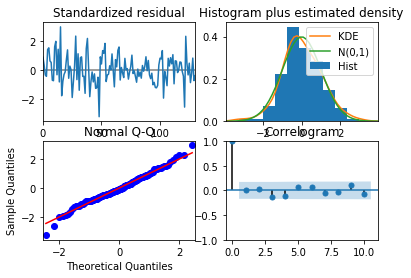

In [63]:
#$my plot diagnostics
model_fit.plot_diagnostics()
plt.show()

## 3. Forecasting
### 3.1 Predict
in sample $todo add margins

In [64]:
#predict
y_hat = model_fit.predict(1,3)
y_hat


1    4.727388
2    4.779123
3    4.890349
dtype: float64

In [65]:
y_hat = model_fit.predict()
y_hat

0      0.000000
1      4.727388
2      4.779123
3      4.890349
4      4.867534
         ...   
139    6.440750
140    6.242116
141    6.106189
142    5.995951
143    6.085619
Length: 144, dtype: float64

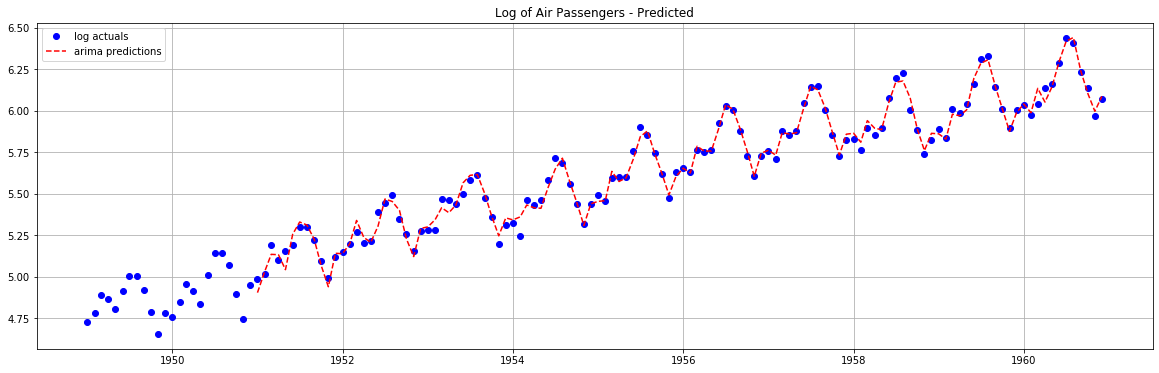

In [66]:
plt.figure(figsize=(20, 6))
plt.plot(x, y, 'bo', label='log actuals')
plt.plot(x[24:], y_hat[24:], 'r--', label='arima predictions')
plt.title('Log of Air Passengers - Predicted')
plt.grid(True)
plt.legend()
plt.show()

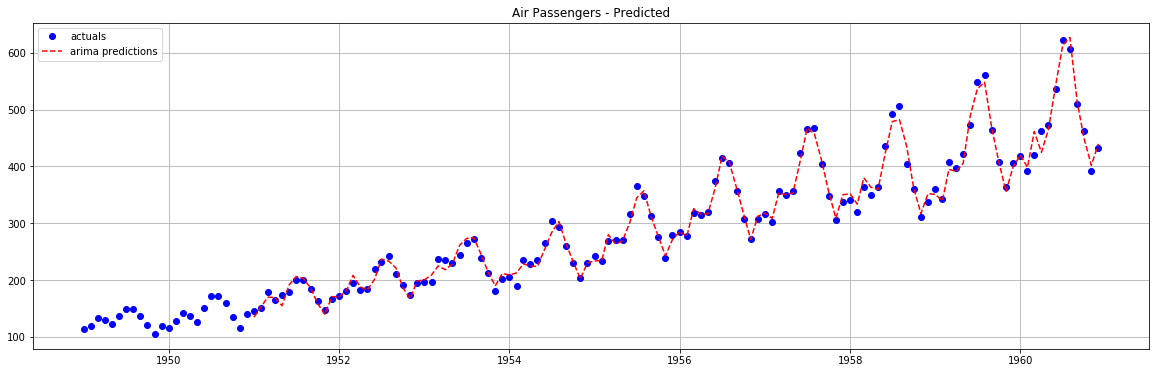

In [67]:
plt.figure(figsize=(20, 6))
plt.plot(x, np.exp(y), 'bo', label='actuals')
plt.plot(x[24:], np.exp(y_hat[24:]), 'r--', label='arima predictions')
plt.title('Air Passengers - Predicted')
plt.grid(True)
plt.legend()
plt.show()

### 3.2 Forecast
out of sample

In [68]:
#forecast multi-step out-of-sample forecast
y_forecast = model_fit.forecast(steps=24)

#preview
print(len(y_forecast))
y_forecast[:5]

24


144    6.112363
145    6.056068
146    6.173576
147    6.201246
148    6.234435
dtype: float64

In [69]:
#$dates - create a date range for df indexing by date
# refer to https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
forecast_start_date = datetime.strptime('01/01/1961', '%d/%m/%Y')
FORECAST_AHEAD = 24
x_forecast_dates = pd.date_range(start=forecast_start_date, periods = FORECAST_AHEAD, freq = 'MS') 

#preview
print(len(x_forecast_dates)) 
x_forecast_dates[:5] #class pandas.core.indexes.datetimes.DatetimeIndex

24


DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [70]:
#confirm dates vs forecast dates before plotting
len(x), len(x_forecast_dates)
x[-5:], x_forecast_dates[:2]

(139   1960-08-01
 140   1960-09-01
 141   1960-10-01
 142   1960-11-01
 143   1960-12-01
 Name: Month, dtype: datetime64[ns],
 DatetimeIndex(['1961-01-01', '1961-02-01'], dtype='datetime64[ns]', freq='MS'))

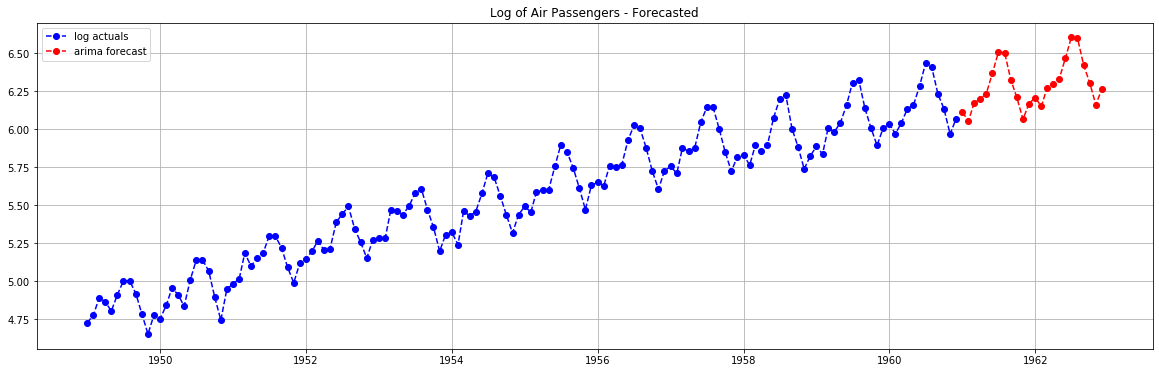

In [71]:
plt.figure(figsize=(20, 6))
plt.plot(x, y, 'bo--', label='log actuals')
plt.plot(x_forecast_dates, y_forecast, 'ro--', label='arima forecast')
plt.title('Log of Air Passengers - Forecasted')
plt.grid(True)
plt.legend()
plt.show()

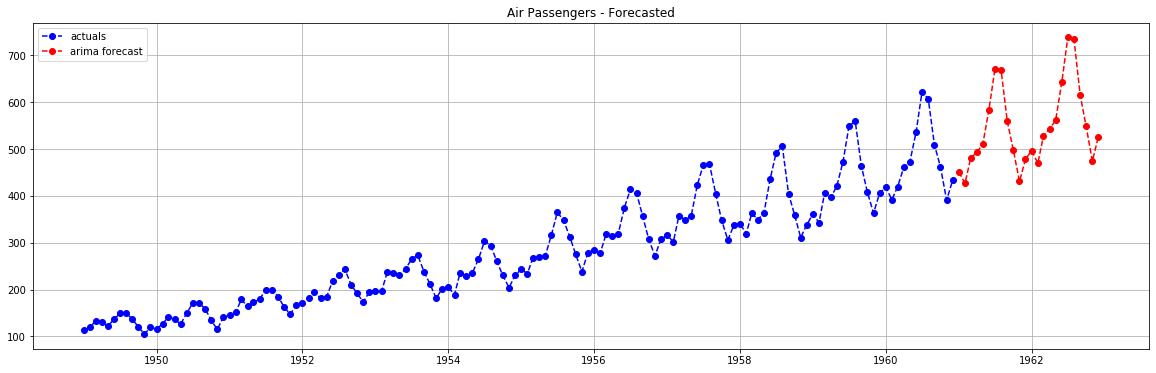

In [72]:
plt.figure(figsize=(20, 6))
plt.plot(x, np.exp(y), 'bo--', label='actuals')
plt.plot(x_forecast_dates, np.exp(y_forecast), 'ro--', label='arima forecast')
plt.title('Air Passengers - Forecasted')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
mystop

## myXtra

In [73]:
#$myXtra
#step thru diff (t-1) and diff of diff(t-3)

#manual
print('manual')
a = np.arange(10)
len_a = a.shape
print(len_a)
print(a, a[:9], a[1:])

d1 = a[1:] - a[:9]
len_d1 = d1.shape
print(len_d1)
print(d1, d1[:6], d1[3:])

d2 = d1[3:] - d1[:6]
len_d2 = d2.shape
print(len_d2)
print(d2)

#dynamic
print('dynamic')
START_LEN = 10
DIFF1 = 1
DIFF2 = 3

a = np.arange(START_LEN)
len_a = a.shape[0]
print(len_a)
print(a, a[:(len_a - DIFF1)], a[DIFF1:])

d1 = a[DIFF1:] - a[:(len_a - DIFF1)]
len_d1 = d1.shape[0]
print(len_d1)
print(d1, d1[:(len_d1 - DIFF2)], d1[DIFF2:])

d2 = d1[DIFF2:] - d1[:(len_d1 - DIFF2)]
len_d2 = d2.shape
print(len_d2)
print(d2)

manual
(10,)
[0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8] [1 2 3 4 5 6 7 8 9]
(9,)
[1 1 1 1 1 1 1 1 1] [1 1 1 1 1 1] [1 1 1 1 1 1]
(6,)
[0 0 0 0 0 0]
dynamic
10
[0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8] [1 2 3 4 5 6 7 8 9]
9
[1 1 1 1 1 1 1 1 1] [1 1 1 1 1 1] [1 1 1 1 1 1]
(6,)
[0 0 0 0 0 0]


## Xtra

#### How to get some R datasets  
`statsmodels v0.12.0` `The Datasets Package`  
refer to https://www.statsmodels.org/v0.12.0/datasets/index.html

In [ ]:
#$xtra
duncan_prestige = sm.datasets.get_rdataset("Duncan", "carData")
duncan_prestige.__doc__ #statsmodels.datasets.utils.Dataset